# 投影和标签转移

嵌入器本身可以作为分类器，因为他根据 kNN 作出了对于相似性的裁决。使用可嵌入新数据（重训练）的嵌入器可以将一个未知数据集和一个已知的数据集
共同嵌入到同一个低维空间中。根据共同的 kNN 图进行分类和聚类；如果我们能够设法保持原嵌入空间不变（使第一次嵌入的数据点仍然在相同的位置），
我们可以对新数据进行投影。PCA 显然支持这样的可重复性，但其受批次效应影响很大，一些非线性方法如 scVI 也可以支持这样的可重复性，并同时校正
批次效应

尽管 UMAP 本身也支持重训练，但是基于神经网络的 UMAP 效能较传统方法更低，而且难以选择合适的超参数。我们使用 MDE 进行嵌入，他较好的支持
重训练，而且可以创建使得原有数据点可重复的约束

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exprmat as em

# set working directory
em.setwd('/home/data/yangz/shared/tutorial/single-cell-rna')
ver = em.version()

[i] exprmat 0.1.48 / exprmat-db 0.1.48
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/shared/tutorial/single-cell-rna
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.48)
[i] resident memory: 808.35 MiB
[i] virtual memory: 5.78 GiB


### 准备参考数据集

我们需要对一个参考图谱进行一些必要的准备，这包括:
- 训练一个 scVI / scANVI 嵌入器
- 获得一个合适的图谱级的二维降维表示

在图谱准备工作完毕后，请保存图谱实验对象，这样才会写到硬盘上

In [7]:
atlas = em.load_experiment(
    direc = 'expression', 
    load_samples = False,
    load_subset = 'mono-neutro'
)

[!] samples are not dumped in the experiment directory.


In [8]:
print(atlas)

annotated data of size 10160 × 19389
subset mono-neutro of size 10160 × 19389
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat> cell.type <cat> score <f64> potency <cat> relative <f64> score.preknn <f64>
          potency.preknn <cat> ppt.pseudotime <f64> ppt.seg <cat> ppt.edge <cat>
          ppt.milestones <cat>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool> n.umi <f64> symbol <cat>
 layers : counts <f32> magic <f64> norm <f32>
   obsm : cnmf.10 <df> diffmap <arr:f32(5)> 

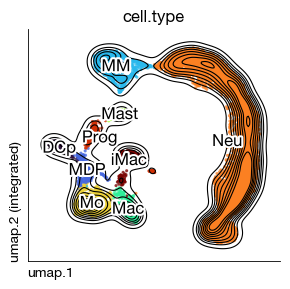

In [10]:
fig = atlas.plot_rna_embedding(
    basis = 'umap', color = 'cell.type', annotate_style = 'text', legend = False,
    figsize = (3, 3), dpi = 100, ptsize = 4, contour_plot = True
)

In [11]:
atlas.run_rna_construct_atlas(
    key_counts = 'counts',
    key_batch = 'batch',
    hvg = 'vst.all.hvg',
    batch_cell_filter = 50,

    # scvi model settings
    scvi_n_epoch = 500,
    scvi_n_latent = 30,
    scvi_n_hidden = 128,
    scvi_n_layers = 2,
    scvi_dropout_rate = 0.1,
    scvi_dispersion = 'gene',
    scvi_gene_likelihood = 'nb',
    scvi_latent_distrib = 'normal',
    scvi_key = 'scvi',

    annotation = 'cell.type',
    scanvi_key = 'scanvi',
    scanvi_unlabel = 'unknown',
    scanvi_max_epochs = 300,
    scanvi_samples_per_label = 250,

    scvi_kwargs = {
        'encode_covariates': True,
        'deeply_inject_covariates': False,
        'use_layer_norm': "both",
        'use_batch_norm': "none",
    },
    scanvi_kwargs = {},
    scanvi_train_kwargs = {
        'early_stopping': True,
        'early_stopping_monitor': 'elbo_validation', 
        'early_stopping_min_delta': 0.001, 
        'early_stopping_patience': 10, 
    },
    scvi_train_kwargs = {
        'early_stopping': True,
        'early_stopping_monitor': 'elbo_validation', 
        'early_stopping_min_delta': 0.0, 
        'early_stopping_patience': 9, 
        'early_stopping_warmup_epochs': 0, 
        'early_stopping_mode': 'min',
        'plan_kwargs': {
            'reduce_lr_on_plateau': True,
            'lr_patience': 8,
            'lr_factor': 0.1,
        }
    }
)

[i] prepare count matrix of size 10160 * 1942


[!] 0 samples is removed due to small sample size.
[i] will train 500 epochs.


Monitored metric elbo_validation did not improve in the last 9 records. Best score: 708.652. Signaling Trainer to stop.
[i] trained scvi model saved.
[i] training scanvi model on label `cell.type`
INFO     Training for 300 epochs.                                                                                  


Monitored metric elbo_validation did not improve in the last 10 records. Best score: 701.353. Signaling Trainer to stop.
[i] trained scanvi model saved.
[i] saving metadata of atlas as a light version.


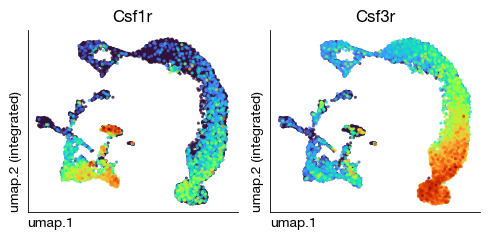

In [34]:
fig = atlas.plot_rna_embedding_multiple(
    basis = 'umap', features = ['Csf1r', 'Csf3r'], ncols = 2, annotate_style = 'text', legend = False,
    figsize = (5, 2.5), dpi = 100, ptsize = 4, contour_plot = False, cmap = 'turbo'
)

In [16]:
atlas.save(save_samples = False)

[i] main dataset write to expression/subsets/mono-neutro.h5mu


### 投影数据集

投影数据集本身不需要太多的准备，便可以对一个已经加载的准备好的参考数据集进行投影。投影数据集的唯一要求是具有原始 UMI 计数矩阵 `counts`

In [17]:
query = em.load_experiment(
    direc = './query-dataset', 
    load_samples = False, load_subset = 'neutrophil'
)

[!] samples are not dumped in the experiment directory.


In [18]:
print(query)

annotated data of size 2359 × 21687
subset neutrophil of size 2359 × 21687
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f32> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat> annot <cat> time <cat> kde.time <f64> cell.type <cat> ppt.pseudotime <f64>
          ppt.seg <cat> ppt.edge <cat> ppt.milestones <cat> n.umi.unspliced <f64>
          n.umi.spliced <f64> velocity.self.transition <f32> root.cells <f64> endpoints <f64>
          velocity.pseudotime <f64> velocity.length <f32> velocity.confidence <f64>
          velocity.confidence.transition <f32>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <o> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
  

`re_embed` 参数可以选择是否要训练一个全新的共同嵌入。如果为 `False`，嵌入器将被约束为使得原有的图谱保持在同一位置，使新的嵌入
直观可视。然而，如果样本密度偏差很大，新的嵌入点可能极端的聚集在很近的位置，而无法展示更细节的结构

In [ ]:
query.run_rna_project(
    atlas = atlas,
    atlas_modality = 'rna',         # must match
    atlas_embedding = 'umap',
    counts_key = 'counts',
    batch_key = 'batch',
    key_query_latent = 'scanvi',
    scanvi_unlabel = 'unknown',     # must match
    scvi_epoch_reduction = 3,
    predict_labels = 'cell.type',
    key_added = 'projection',

    # mde settings
    re_embed = False,                # whether to re-embed the data:
                                    # set re-embed to False will preserve the atlas embedding as is, and fit the 
                                    # query dataset directly onto it.
    max_iter = 500,
    verbose = True,
)

In [20]:
print(query)

annotated data of size 2359 × 21687
subset neutrophil of size 2359 × 21687
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f32> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat> annot <cat> time <cat> kde.time <f64> cell.type <cat> ppt.pseudotime <f64>
          ppt.seg <cat> ppt.edge <cat> ppt.milestones <cat> n.umi.unspliced <f64>
          n.umi.spliced <f64> velocity.self.transition <f32> root.cells <f64> endpoints <f64>
          velocity.pseudotime <f64> velocity.length <f32> velocity.confidence <f64>
          velocity.confidence.transition <f32>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <o> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
  

In [21]:
query['rna'].uns['projection']

,batch,annotation,x,y
distal:2,b1,Neu,0.552455,-0.506204
distal:3,b1,Neu,0.886813,0.278440
distal:4,b1,Neu,1.364757,1.714306
distal:8,b1,Neu,0.649117,0.105026
distal:9,b1,Neu,1.751073,1.096886
...,...,...,...,...
normal:4656,b3,Mo,-4.326916,-0.979434
normal:4657,b3,MDP,-4.444282,0.809895
normal:4658,b3,Neu,1.215800,1.126136
normal:4661,b3,Neu,1.796268,2.221773


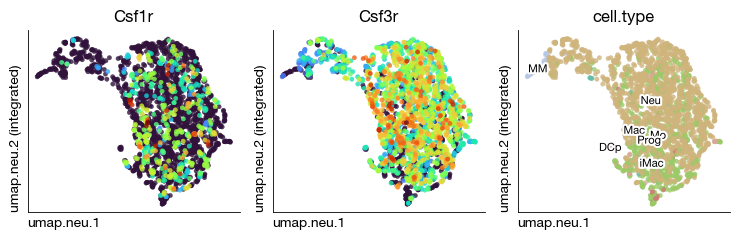

In [33]:
fig = query.plot_rna_embedding_multiple(
    basis = 'umap.neu', features = ['Csf1r', 'Csf3r', 'cell.type'], ncols = 3,
    annotate_style = 'text', legend = False, annotate_fontsize = 8,
    figsize = (7.5, 2.5), dpi = 100, ptsize = 10, contour_plot = False, cmap = 'modlight'
)

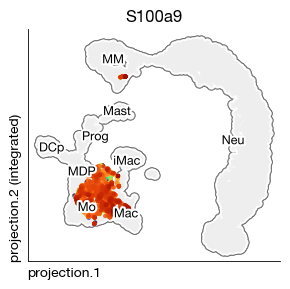

In [28]:
# re-embed = False
fig = query.plot_rna_projection(
    color = 'S100a9', cmap = 'turbo',
    figsize = (3, 3), dpi = 100, projection_key = 'projection',
    contour_plot = False, 
    contour_fill = False,
    contour_levels = 3,
    contour_bw = 2,

    # atlas background
    background = 'annotation',
    annotate = True, annotate_fontsize = 9, 
)

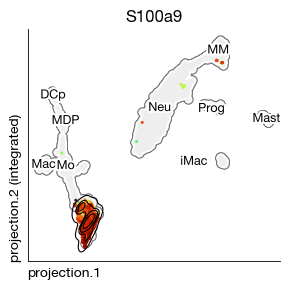

In [25]:
# re-embed = True
fig = query.plot_rna_projection(
    color = 'S100a9', cmap = 'turbo',
    figsize = (3, 3), dpi = 100, projection_key = 'projection',
    contour_plot = True, 
    contour_fill = False,
    contour_levels = 5,
    contour_bw = 1,
    ptsize = 4, alpha = 1,

    # atlas background
    background = 'annotation',
    annotate = True, annotate_fontsize = 9, 
)

In [ ]:
query.save(save_samples = False)